## 导入包


In [15]:
# 基础的数据处理工具
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # 可视化
import datetime # 处理python时间函数
import netCDF4 as nc  # 处理nc数据
from netCDF4 import num2date  # 处理nc数据
import geopandas as gpd  # 处理网格数据，shp之类的
import rasterio  # 处理tiff文件
from shapely.geometry import Point  # gis的一些逻辑判断
from cartopy import crs as ccrs  # 设置投影坐标系等
from tqdm import tqdm  # 打印进度条
from joblib import Parallel, delayed  # 并行
import platform  # 检测系统

tqdm.pandas()

# matplotlib 显示中文的问题
if platform.system() == 'Darwin':
    plt.rcParams["font.family"] = 'Arial Unicode MS'
elif platform.system() == 'Windows':
    plt.rcParams["font.family"] = 'SimHei'
else:
    pass

In [16]:
nc_data = nc.Dataset("./数据集/GIS实践3/2016_2020.nc")

In [17]:
for item in nc_data.variables.values():
    print('*' * 70)
    print(item)

**********************************************************************
<class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (31,)
filling on, default _FillValue of 9.969209968386869e+36 used
**********************************************************************
<class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (21,)
filling on, default _FillValue of 9.969209968386869e+36 used
**********************************************************************
<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (43848,)
filling on, default _FillValue of -2147483647 used
**********************************************************************
<class 'netCDF4._netCDF4.Variable'>
i

/var/folders/rn/1sl8q5g56bb377glk8qyp_k40000gn/T/ipykernel_69333/1695638433.py:3: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  print(item)


In [18]:
nc_data.variables.keys()

dict_keys(['longitude', 'latitude', 'time', 'u10', 'v10'])

In [20]:
raw_latitude = np.array(nc_data.variables['latitude'])
raw_longitude = np.array(nc_data.variables['longitude'])
raw_time = np.array(nc_data.variables['time'])
raw_u10 = np.array(nc_data.variables['u10'])
raw_v10 = np.array(nc_data.variables['v10'])
# 提取缺失值，并且将缺失值替换
missing_u10_value = nc_data.variables['u10'].missing_value
missing_v10_value = nc_data.variables['v10'].missing_value
raw_v10[raw_v10 == missing_v10_value] = np.nan
raw_u10[raw_u10 == missing_u10_value] = np.nan

/var/folders/rn/1sl8q5g56bb377glk8qyp_k40000gn/T/ipykernel_69333/1228877816.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  raw_latitude = np.array(nc_data.variables['latitude'])
/var/folders/rn/1sl8q5g56bb377glk8qyp_k40000gn/T/ipykernel_69333/1228877816.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  raw_longitude = np.array(nc_data.variab

In [21]:
# 处理时间
def cftime2datetime(cftime, units, format='%Y-%m-%d %H:%M:%S'):
    """
    将nc文件里面的时间格式 从cftime 转换到 datetime格式
    :param cftime:
    :param units:
    :param format:
    :return:
    """
    return datetime.datetime.strptime(num2date(times=cftime, units=units).strftime(format), format)

clean_time_data = pd.Series([cftime2datetime(i, units=str(nc_data.variables['time'].units)) for i in tqdm(raw_time)])
clean_time_data[:4]


  0%|          | 0/43848 [00:00<?, ?it/s]/var/folders/rn/1sl8q5g56bb377glk8qyp_k40000gn/T/ipykernel_69333/3178292432.py:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  clean_time_data = pd.Series([cftime2datetime(i, units=str(nc_data.variables['time'].units)) for i in tqdm(raw_time)])
100%|██████████| 43848/43848 [00:05<00:00, 7891.44it/s]


0   2016-01-01 00:00:00
1   2016-01-01 01:00:00
2   2016-01-01 02:00:00
3   2016-01-01 03:00:00
dtype: datetime64[ns]

In [28]:
windspeed_mean = pd.Series([np.sqrt(raw_v10[i,:, :] ** 2 + raw_u10[i, :, :]**2).mean() for i in tqdm(range(clean_time_data.shape[0]))])

time_windspeed = pd.DataFrame({'time':clean_time_data,'mean_ws':windspeed_mean})
time_windspeed

100%|██████████| 43848/43848 [00:00<00:00, 55483.92it/s]


,time,mean_ws
0,2016-01-01 00:00:00,3.931938
1,2016-01-01 01:00:00,3.781770
2,2016-01-01 02:00:00,3.465095
3,2016-01-01 03:00:00,3.694399
4,2016-01-01 04:00:00,4.139895
...,...,...
43843,2020-12-31 19:00:00,6.239145
43844,2020-12-31 20:00:00,6.239377
43845,2020-12-31 21:00:00,6.254214
43846,2020-12-31 22:00:00,6.213076


## 年维度风速数据

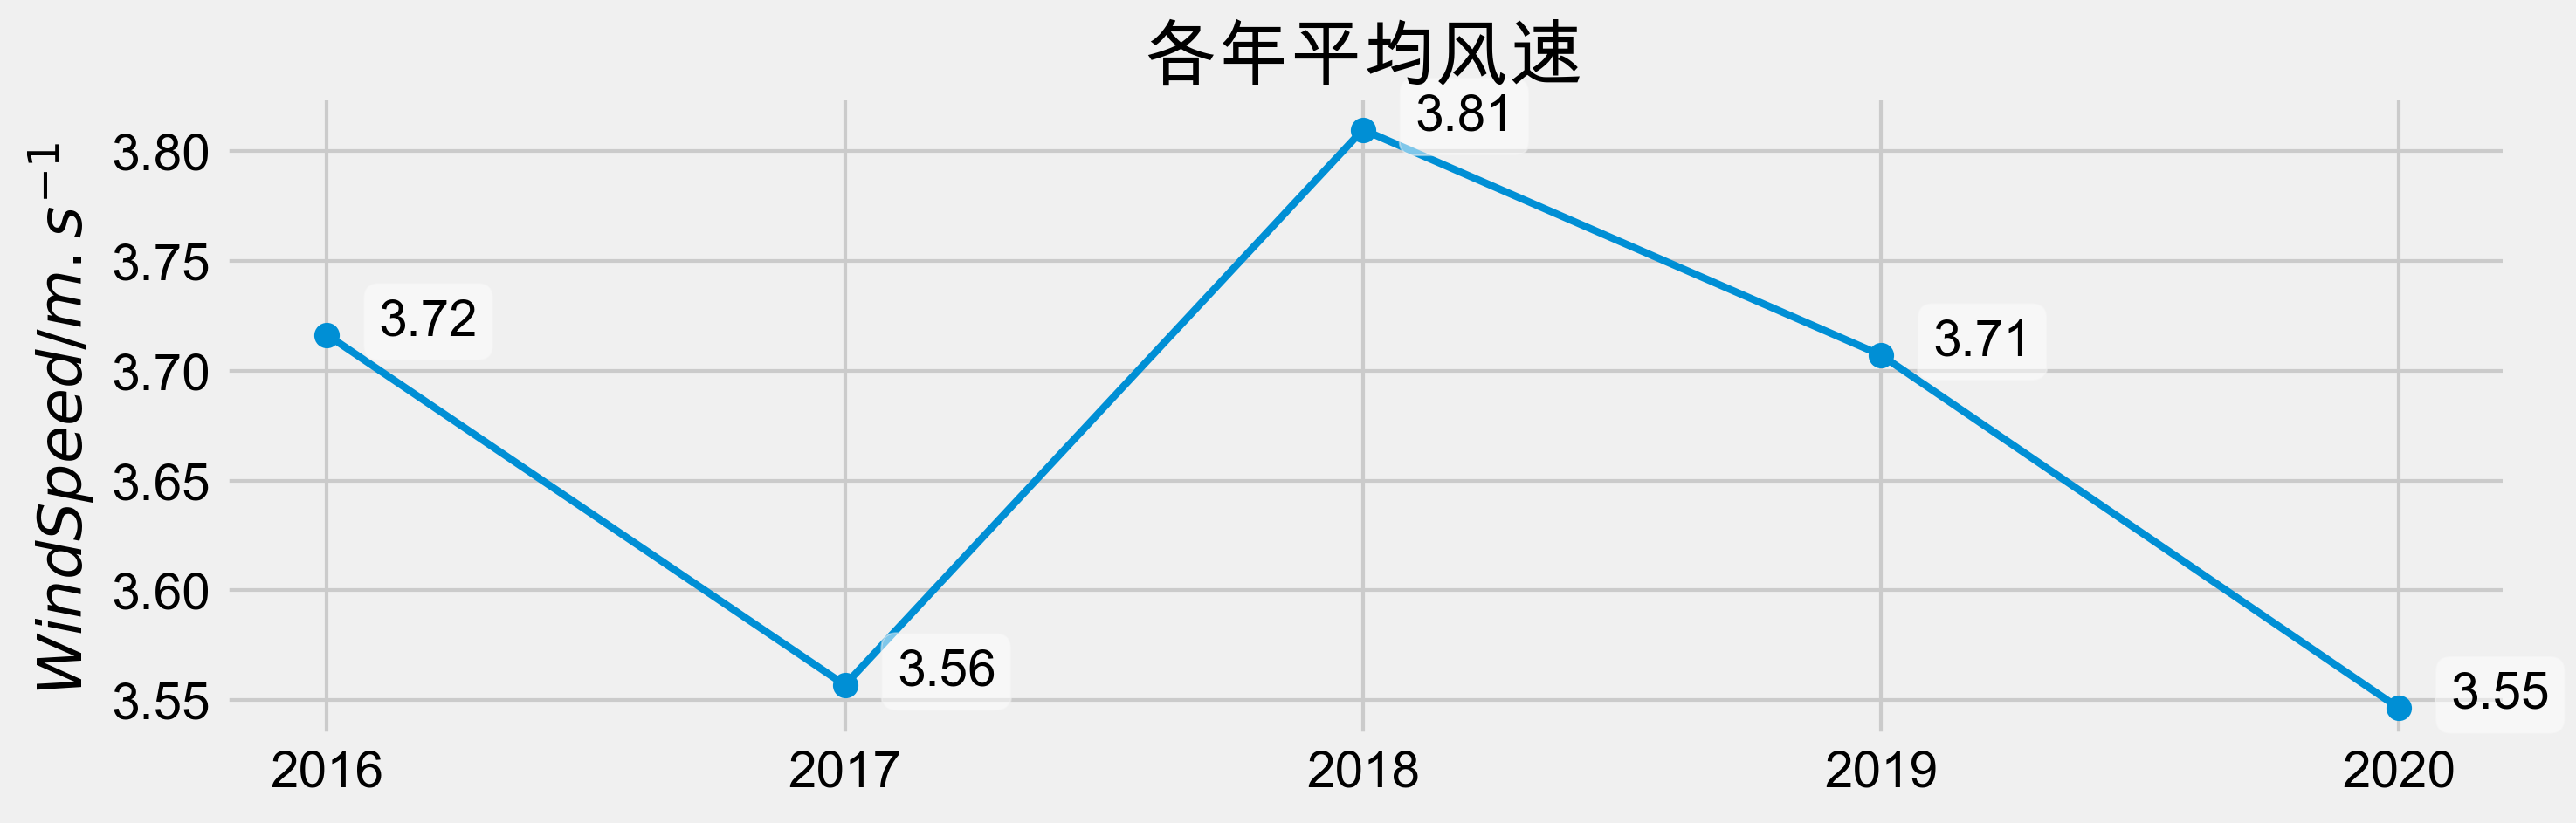

In [127]:
year_data = time_windspeed.groupby(time_windspeed.time.dt.year).agg(
    mean_ws = ('mean_ws', 'mean')
).reset_index()

# year_data

with plt.style.context('fivethirtyeight') as style:

    fig, ax = plt.subplots(figsize=(10,3), dpi=300)
    ax.plot(year_data['time'], year_data['mean_ws'], '-o',linewidth=2, ms=6)
    ax.set_xticks(year_data['time'])
    #
    #
    for i in range(year_data.shape[0]):
        ax.text(year_data.iloc[i]['time']+0.1, year_data.iloc[i]['mean_ws'], str(np.around(year_data.iloc[i]['mean_ws'], 2)),
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    #
    for i in ['top', 'right']:
        ax.spines[i].set_visible(False)

    ax.set_title("各年平均风速")
    ax.set_ylabel("$Wind Speed / m.s^{-1}$")

## 月维度风速数据

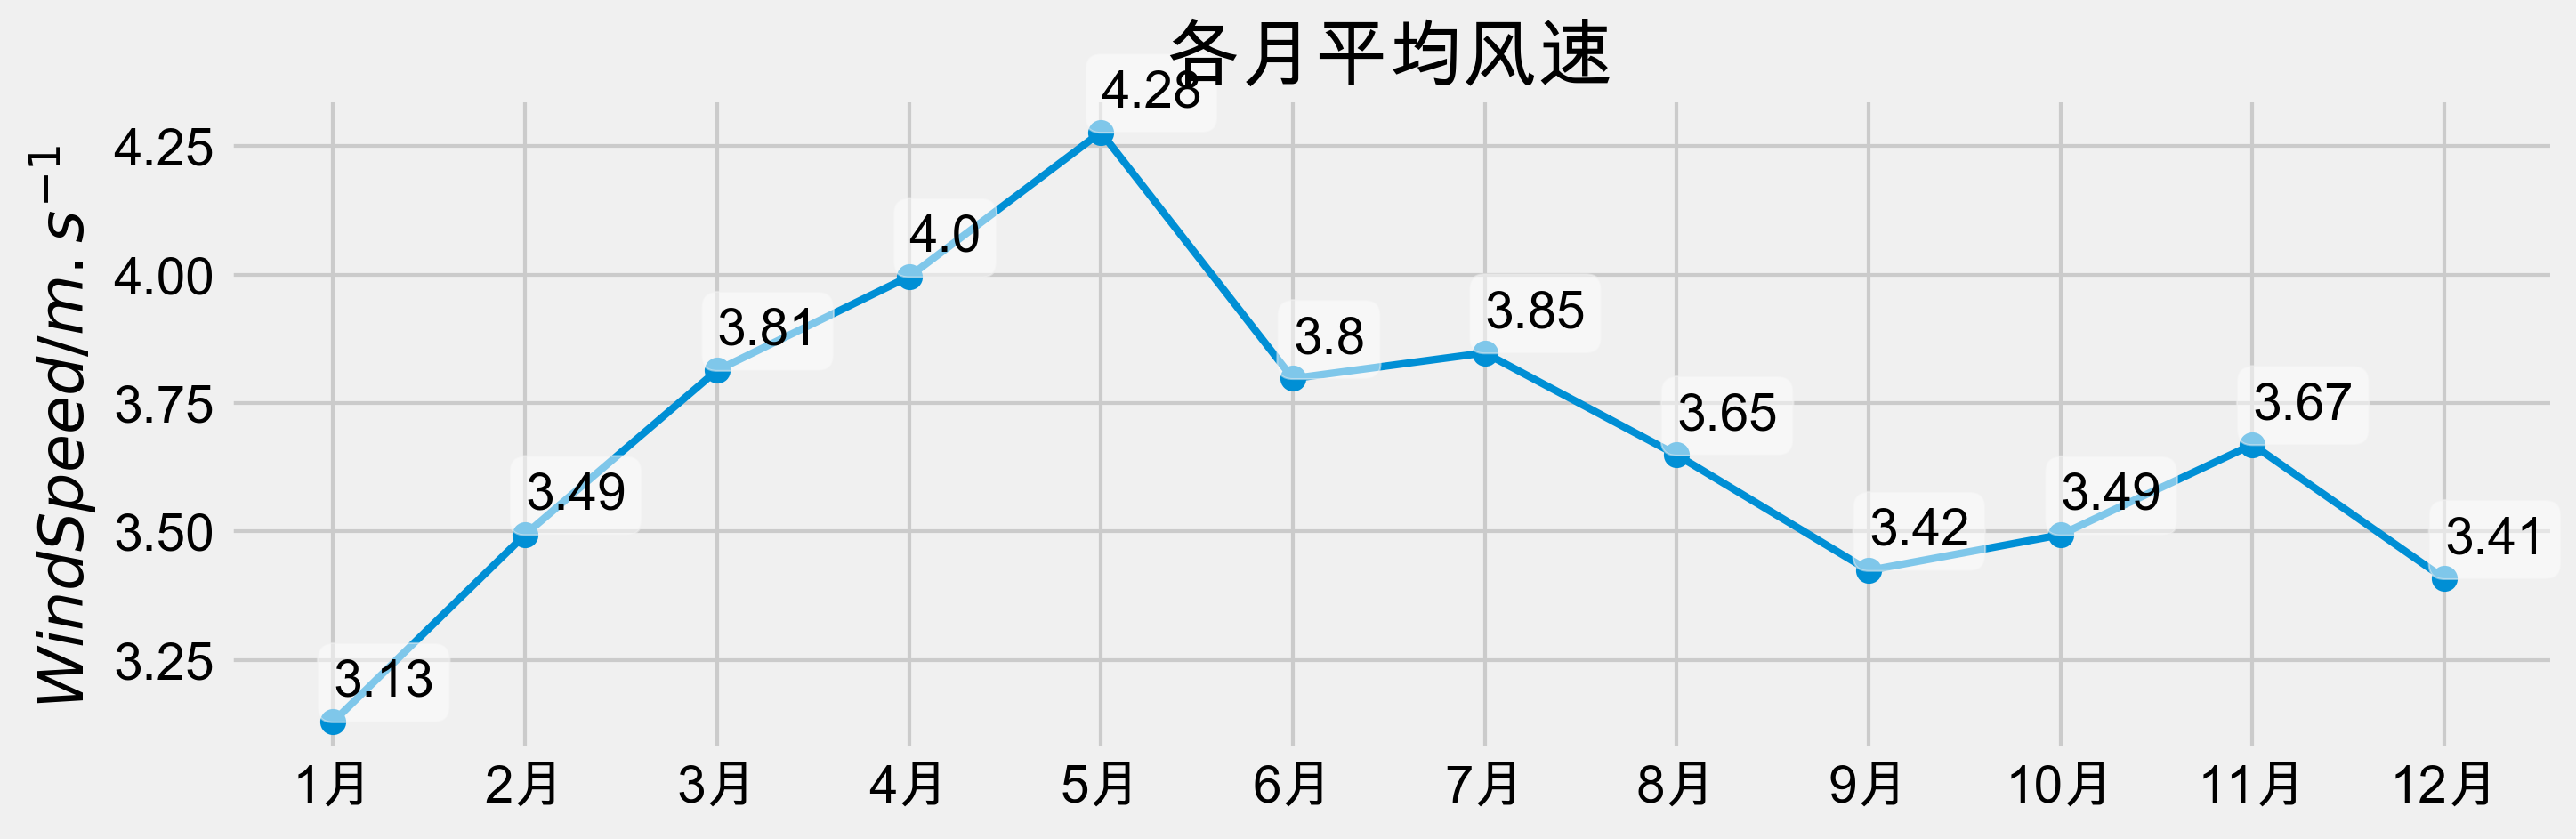

In [126]:
month_data = time_windspeed.groupby(time_windspeed.time.dt.month).agg(
    mean_ws = ('mean_ws', 'mean')
).reset_index()


with plt.style.context('fivethirtyeight') as style:

    fig, ax = plt.subplots(figsize=(10,3), dpi=300)
    ax.plot(month_data['time'], month_data['mean_ws'], '-o',linewidth=2, ms=6)
    ax.set_xticks(month_data['time'])
    _ = ax.set_xticklabels(labels=[f'{i}月' for i in month_data['time']])


    for i in range(month_data.shape[0]):
        ax.text(month_data.iloc[i]['time'], month_data.iloc[i]['mean_ws']+0.05, str(np.around(month_data.iloc[i]['mean_ws'], 2)),
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    for i in ['top', 'right']:
        ax.spines[i].set_visible(False)

    ax.set_title("各月平均风速")
    ax.set_ylabel("$Wind Speed / m.s^{-1}$")

## 天维度数据

In [123]:
day_data = time_windspeed.groupby(time_windspeed.time.apply(lambda x: x.strftime('%Y-%m-%d'))).agg(
    mean_ws = ('mean_ws', 'mean')
).reset_index()

day_data['time'] = pd.to_datetime(day_data['time'])

day_data = day_data.set_index('time')
day_data.head()

,mean_ws
time,
2016-01-01,3.536429
2016-01-02,4.532798
2016-01-03,3.655634
2016-01-04,2.943458
2016-01-05,1.906726


Text(0.5, 0, 'date')

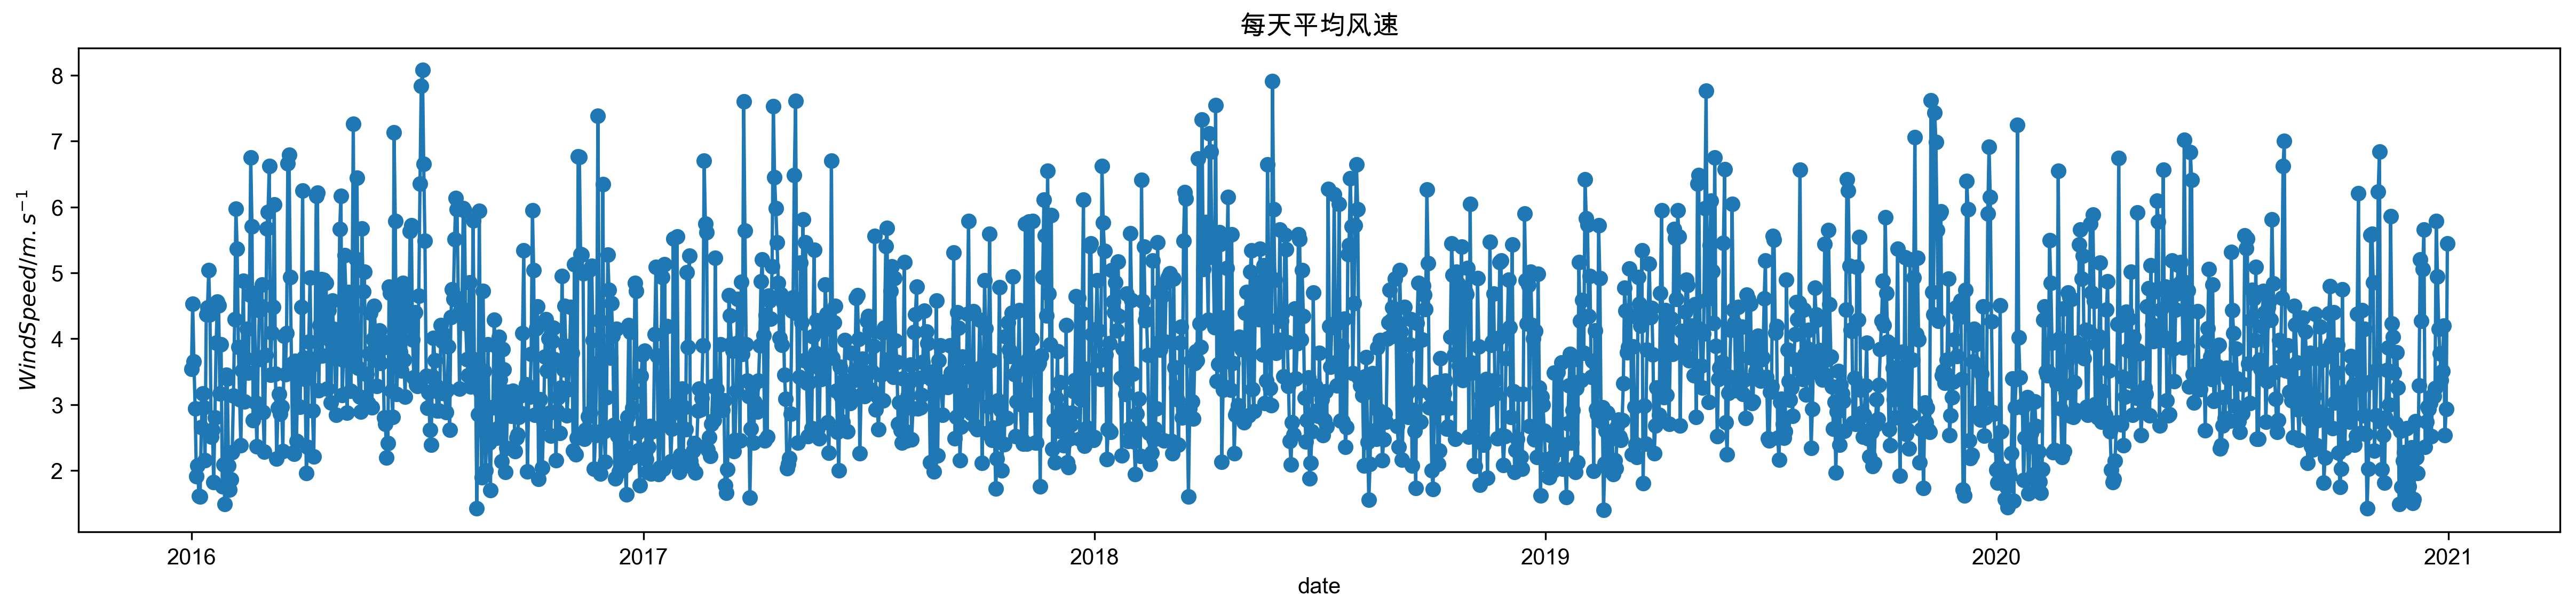

In [124]:
# day_data.dtypes
fig, ax = plt.subplots(figsize=(20,4), dpi=300)
ax.plot(day_data.index, day_data['mean_ws'], '-o')
# ax.xaxis.set_ticks_position('none')
# ax.tick_params(axis="x", labelbottom=False)
ax.set_title("每天平均风速")
ax.set_ylabel("$Wind Speed / m.s^{-1}$")
ax.set_xlabel("date")

## 时间序列的趋势分解

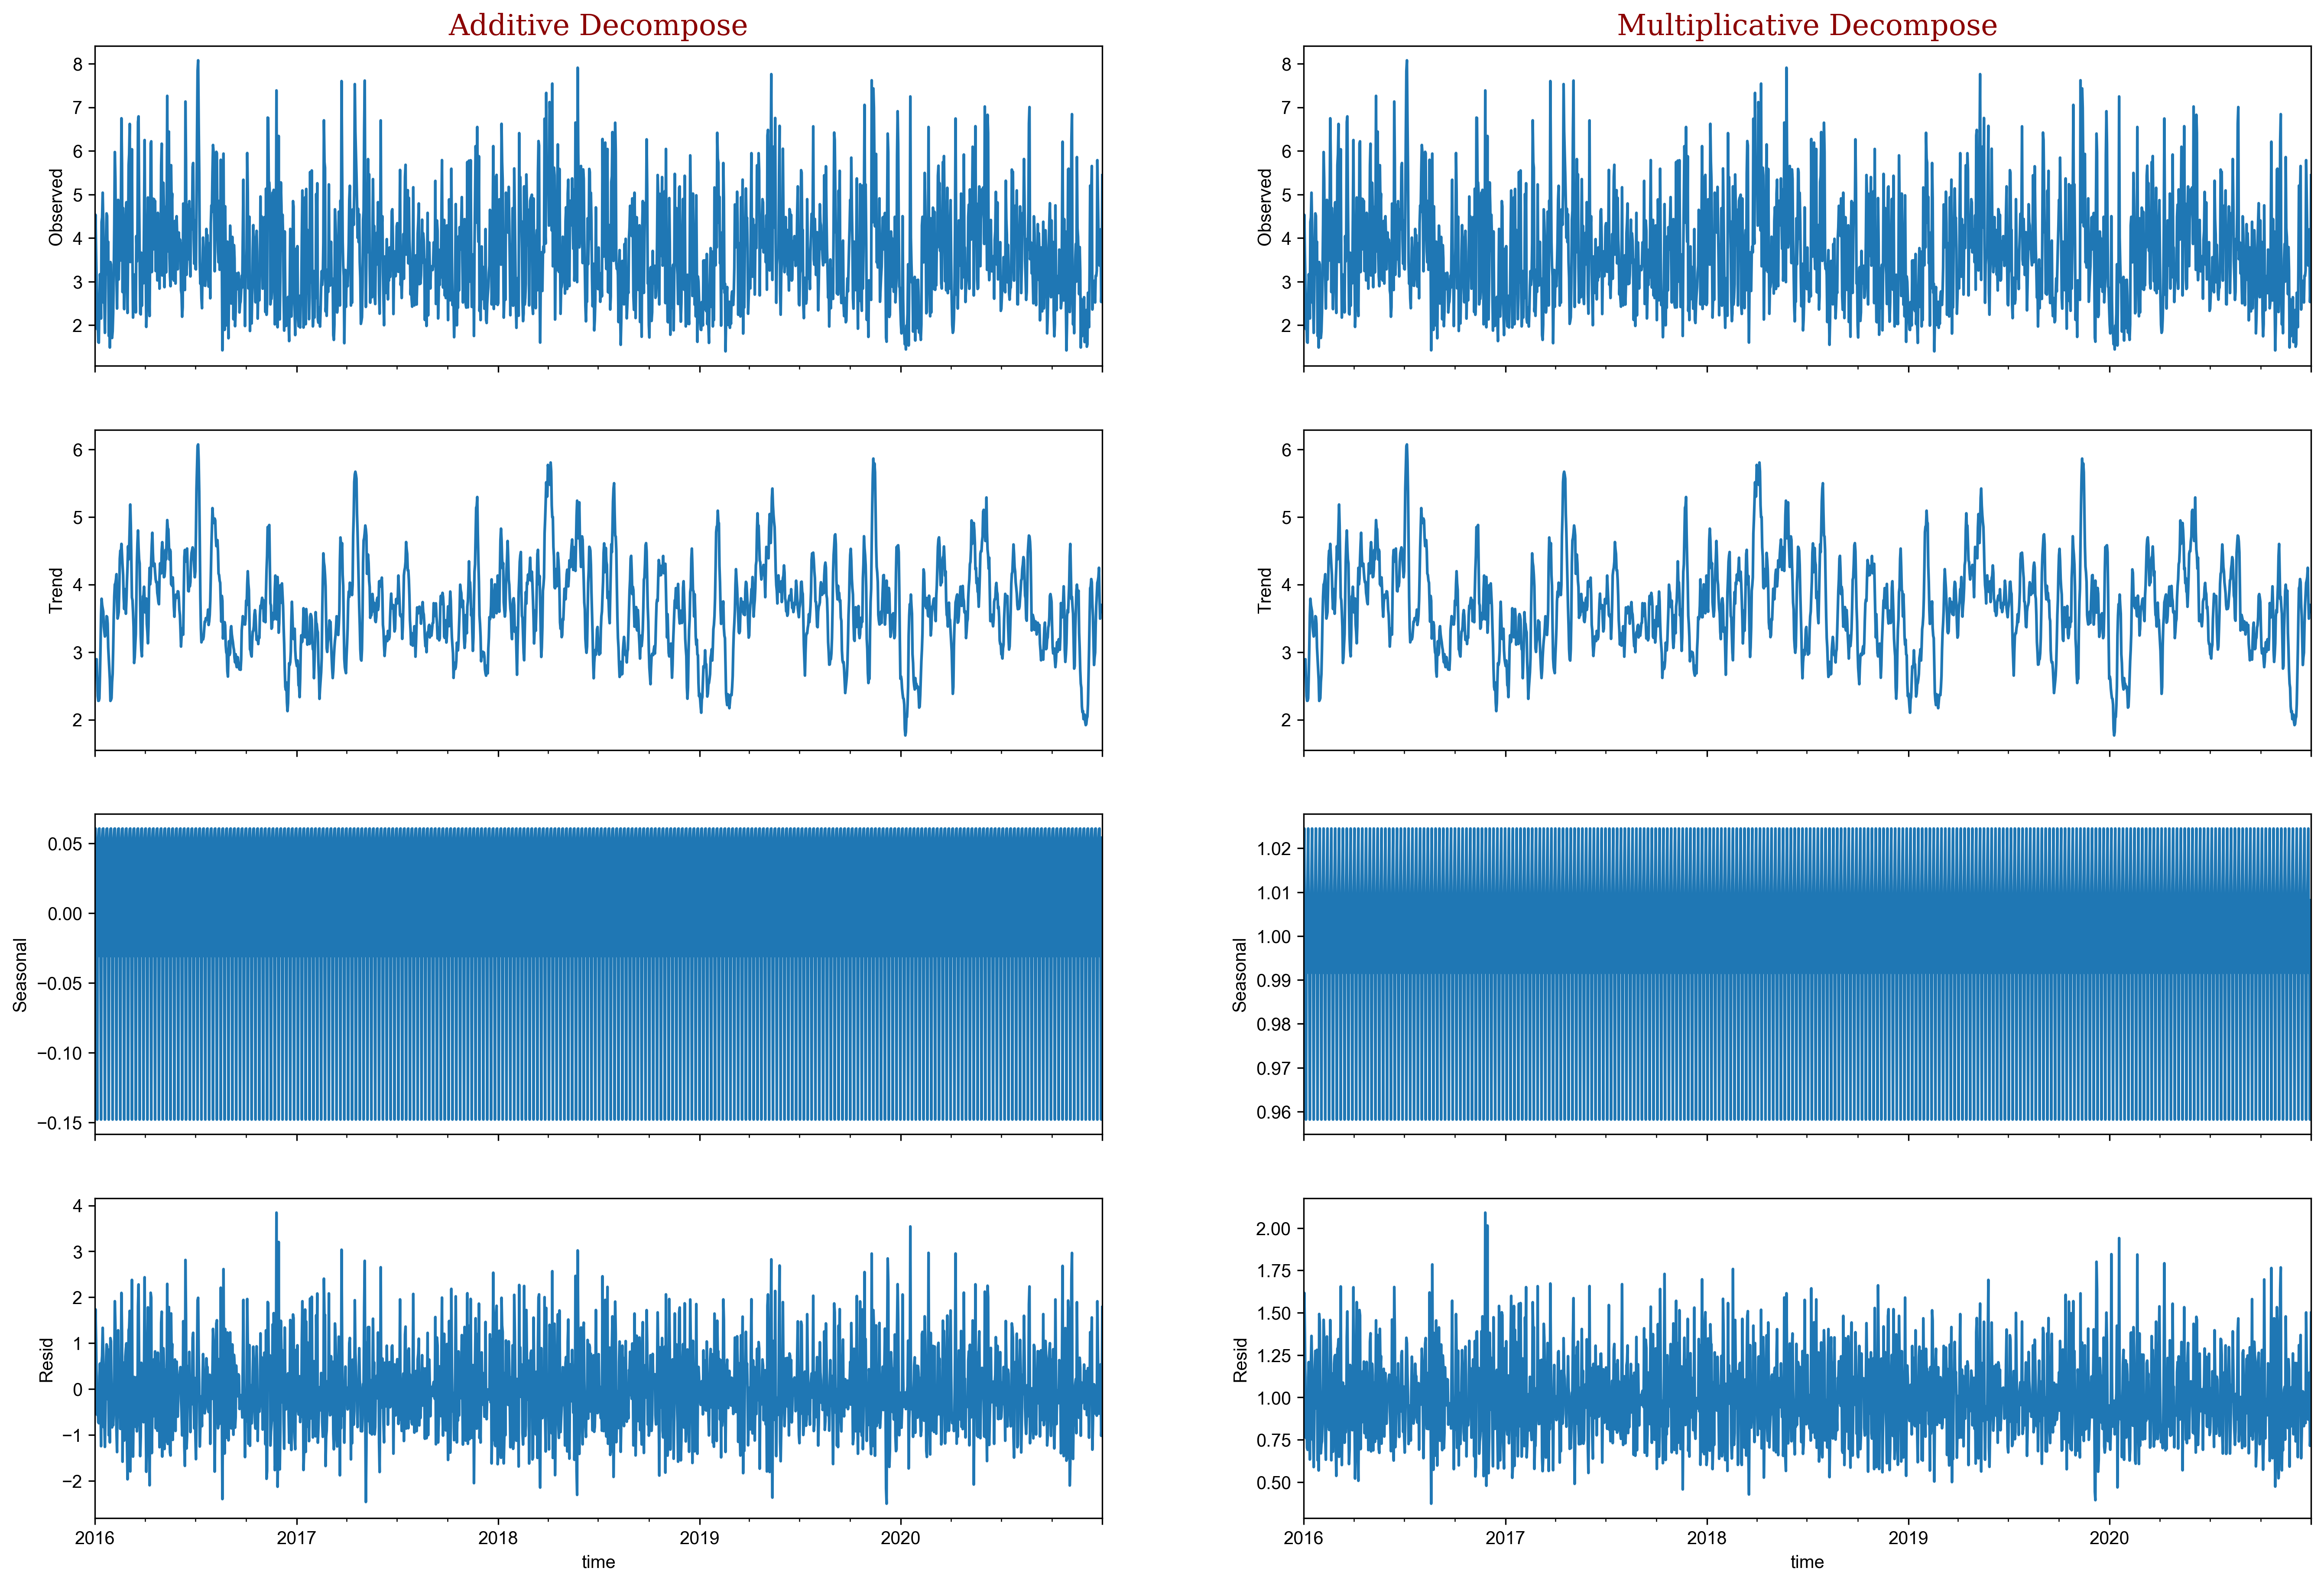

In [114]:
# 导入包
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
# 乘法模型
result_mul = seasonal_decompose(day_data['mean_ws'], model="multilicative", extrapolate_trend='freq')
result_add = seasonal_decompose(day_data['mean_ws'], model="additive", extrapolate_trend='freq')
font = {'family': 'serif',
        'color': 'darkred',
        'weight': 'normal',
        'size': 16,
        }
# 画图
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(22, 15), sharex=True, dpi=300)


def plot_decompose(result, ax, index, title, fontdict=font):
    ax[0, index].set_title(title, fontdict=fontdict)
    result.observed.plot(ax=ax[0, index])
    ax[0, index].set_ylabel("Observed")

    result.trend.plot(ax=ax[1, index])
    ax[1, index].set_ylabel("Trend")

    result.seasonal.plot(ax=ax[2, index])
    ax[2, index].set_ylabel("Seasonal")

    result.resid.plot(ax=ax[3, index])
    ax[3, index].set_ylabel("Resid")


plot_decompose(result=result_add, ax=ax, index=0, title="Additive Decompose", fontdict=font)
plot_decompose(result=result_mul, ax=ax, index=1, title="Multiplicative Decompose", fontdict=font)